In [14]:
from models import LSTMModel
import torch
import lightning
import utils
import numpy as np


In [15]:
model = LSTMModel.load_from_checkpoint("lstm-logs/LSTM-lr=0.001 hidden_size=16 num_layer=3/checkpoints/epoch=94-step=3515.ckpt",
                                       hparams_file="lstm-logs/LSTM-lr=0.001 hidden_size=16 num_layer=3/hparams.yaml", map_location={"cuda:0": "cpu"})
model


LSTMModel(
  (lstm): LSTM(3, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (criterion): MSELoss()
)

Mean Squared Error: 12.453245
Root Mean Squared Error: 3.5289156


/tmp/ipykernel_43561/3810073119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = preds * std[0] + mu[0]
/tmp/ipykernel_43561/3810073119.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true = true * std[0] + mu[0]


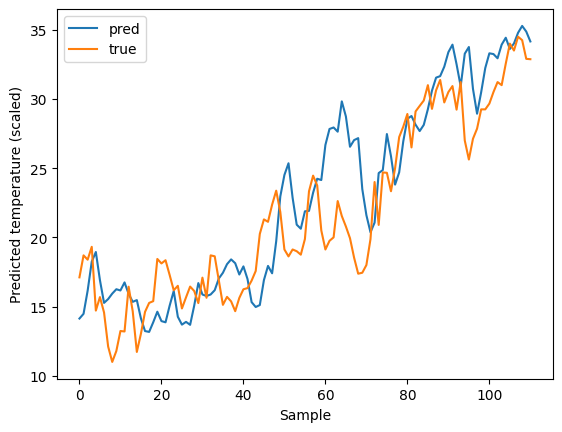

In [16]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


SEQ_LENGTH = 2

df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()
dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

preds, true = utils.predict(model, dataloader_test)
preds = preds * std.iloc[0] + mu.iloc[0]
true = true * std.iloc[0] + mu.iloc[0]

mse = mean_squared_error(true, preds)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
plt.plot(preds, label="pred")
plt.plot(true, label="true")
plt.xlabel('Sample')
plt.ylabel('Predicted temperature (scaled)')
plt.legend()
plt.show()
